In [1]:
%matplotlib inline

## [Feature Extraction - Images]()


## Patches: [Extract](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.image.extract_patches_2d.html#sklearn.feature_extraction.image.extract_patches_2d) and [Reconstruct](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.image.reconstruct_from_patches_2d.html#sklearn.feature_extraction.image.reconstruct_from_patches_2d)
- extract & rebuild to/from a 2D array, or 3D with color information on the 3rd axis.

In [3]:
import numpy as np
from sklearn.feature_extraction import image

# generate 4x4 pixel picture w/ 3 color channels (RGB)
one_image = np.arange(4 * 4 * 3).reshape((4, 4, 3))
one_image[:, :, 0]  # R channel of a fake RGB picture

patches = image.extract_patches_2d(one_image, (2, 2), max_patches=2,
    random_state=0)

print(patches.shape, patches[:, :, :, 0])

patches = image.extract_patches_2d(one_image, (2, 2))
print(patches.shape, patches[4, :, :, 0])

(2, 2, 2, 3) [[[ 0  3]
  [12 15]]

 [[15 18]
  [27 30]]]
(9, 2, 2, 3) [[15 18]
 [27 30]]


In [4]:
# reconstruct original image by averaging on overlapping areas
reconstructed = image.reconstruct_from_patches_2d(patches, 
                                                  (4, 4, 3))
np.testing.assert_array_equal(one_image, 
                              reconstructed)

- [Patch Extractor](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.image.PatchExtractor.html#sklearn.feature_extraction.image.PatchExtractor) works like extract_patches_2d & supports multiple images. It's an estimator so it can be used in pipelines.

In [5]:
five_images = np.arange(5 * 4 * 4 * 3).reshape(5, 4, 4, 3)
patches = image.PatchExtractor(patch_size=(2, 2)).transform(five_images)
patches.shape

(45, 2, 2, 3)

## Connectivity Graphs
- Some estimators use connectivity information. [Ward clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering), for example, clusters neighboring pixel image to form patches. Estimators use a connectivity matrix to do this.
- [Image to Graph](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.image.img_to_graph.html#sklearn.feature_extraction.image.img_to_graph) - returns a connectivity matrix from a 2D or 3D image.
- [Grid to Graph](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.image.grid_to_graph.html#sklearn.feature_extraction.image.grid_to_graph) - builds connectivity matrix for images.

## [Example: Ward hierarchical clustering, coins](https://scikit-learn.org/stable/auto_examples/cluster/plot_coin_ward_segmentation.html#sphx-glr-auto-examples-cluster-plot-coin-ward-segmentation-py)

In [6]:
import time as time
import numpy as np
from distutils.version import LooseVersion
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import skimage
from skimage.data import coins
from skimage.transform import rescale
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering

In [7]:
# these were introduced in skimage-0.14
if LooseVersion(skimage.__version__) >= '0.14':
    rescale_params = {'anti_aliasing': False, 'multichannel': False}
else:
    rescale_params = {}

In [8]:
orig_coins = coins()

# Resize to 20% of original - faster processing
# Apply Gaussian filter for smoothing prior to down-scaling
# reduces aliasing artifacts.
smoothened_coins = gaussian_filter(orig_coins, 
                                   sigma = 2)
rescaled_coins = rescale(smoothened_coins, 
                         0.2, 
                         mode="reflect",
                         **rescale_params)

X = np.reshape(rescaled_coins, (-1, 1))

In [9]:
connectivity = grid_to_graph(*rescaled_coins.shape)
print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 27  # number of regions
ward = AgglomerativeClustering(n_clusters=n_clusters, 
                               linkage='ward',
                               connectivity=connectivity)
ward.fit(X)
label = np.reshape(ward.labels_, 
                   rescaled_coins.shape)
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", label.size)
print("Number of clusters: ", np.unique(label).size)

Compute structured hierarchical clustering...
Elapsed time:  0.3264007568359375
Number of pixels:  4697
Number of clusters:  27


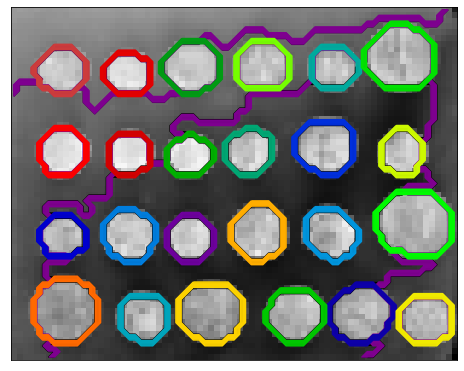

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(rescaled_coins, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(label == l,
                colors=[plt.cm.nipy_spectral(l / float(n_clusters)), ])
plt.xticks(())
plt.yticks(())
plt.show()